In [1]:
library(moments)
library(ggplot2)
library(caTools)
library(randomForest)
library(readr)
library(caret)

train_scores <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv")
train_logs <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv")
sample_submission <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv")
test_logs <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv")
test_scores <- data.frame(id = unique(test_logs$id))

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress




# DATA CLEANING

In [2]:
#Combine Event Columns
train_logs <- train_logs[, names(train_logs) != "up_event"]
names(train_logs)[names(train_logs) == "down_event"] <- "event"


#Simplify Move Activities
i <- 1
while (i <= nrow(train_logs)) {
  if (substr(train_logs$activity[i+1], 1, 1) == "M" & train_logs$event[i] == "Leftclick" & train_logs$text_change[i] == "NoChange") {
    
    new_text <- sub(".*?(\\[.*?\\]).*", "\\1", train_logs$activity[i + 1])
    train_logs$text_change[i] = paste0("Highlighted ", new_text)
    train_logs$activity[i+1] <- "Move"
    rm(new_text)
    
  }
  i <- i + 1
}

#Remove extra movement info from 'undo' rows & convert to factor
train_logs[substr(train_logs$activity, 1, 1) == "M" & train_logs$event == "z", ]$activity <- "Move"
train_logs$activity <- as.factor(train_logs$activity)
str(train_logs$activity)


#Simplify Event Values
train_logs$event <- gsub("(?i)(F[0-9]{1,2}|.*Media.*|.*Audio.*|.*Pause.*).*", "DeviceFeatureChangeKey", train_logs$event)
train_logs$event <- gsub("(?i)(Scroll.*|Meta|Dead|Process|OS|AltGraph|Mode.*)", "SpecialProcessKey", train_logs$event)
train_logs$event <- gsub("(?i)(Clear|Cancel)", "Escape", train_logs$event)
train_logs$event <- gsub("^[0-9]$", "DigitKey", train_logs$event)
train_logs$event <- gsub("(?i).*Arrow.*", "ArrowKey", train_logs$event)
train_logs$event <- gsub("(?i)(Home|End|^Page.*)", "TextJumpKey", train_logs$event)

#Compile list of allowed event values
event_labels <- c("^[A-Za-z]$", "^[[:punct:]]$", "click", "Shift", "Space", "Backspace", "Enter", "Tab", "Caps", "Control", "Delete", "Insert", "Escape", "Print", "RareKey", "NumLock", "Alt", "ContextMenu", "ArrowKey", "TextJumpKey", "DeviceFeatureChangeKey", "SpecialProcessKey", "DigitKey", "Unidentified")
valid_events <- unique(train_logs$event)[apply(sapply(event_labels, function(x) grepl(x, unique(train_logs$event))), 1, any)]

#Replace remaining event values with "Unidentified"
cat("\n", "\n", "INVALID VALUES: ")
print(table(train_logs$event, exclude = valid_events))
train_logs$event <- ifelse(train_logs$event %in% valid_events, train_logs$event, "Unidentified")

cat("\n", "RARE VALUES: ")
print(names(which(table(train_logs$event) < 25)))
train_logs$event[train_logs$event %in% names(which(table(train_logs$event) < 25))] <- "RareKey"

cat("\n", "REMAINING VALUES: ")
print(unique(train_logs$event))
cat("Total 'Event' Values: ", length(unique(train_logs$event)))

#Convert event variable to factor and check
train_logs$event <- as.factor(train_logs$event)
str(train_logs$event)

 Factor w/ 6 levels "Input","Move",..: 3 3 3 1 1 1 1 1 1 1 ...

 
 INVALID VALUES: 
       \u0096        \u009b        \u0097        \u0080             ¡ 
            2             1            14             1             1 
            ¿ â\u0080\u0093       Å\u009f             ä            Â´ 
            2             4             1             1             1 
           Ä±       Ë\u0086 
            3             1 

 RARE VALUES:  [1] "_"            "{"            "}"            "@"            "#"           
 [6] "`"            "^"            "|"            "~"            "A"           
[11] "b"            "C"            "d"            "e"            "f"           
[16] "F"            "g"            "h"            "i"            "I"           
[21] "j"            "l"            "m"            "M"            "Middleclick" 
[26] "n"            "o"            "p"            "r"            "S"           
[31] "t"            "T"            "u"            "Unknownclick" "V"           

# FEATURE ENGINEERING

In [3]:
total_events <- function(logs, scores) {
  result <- aggregate(event_id ~ id, data = logs, FUN = max)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "event_id"] <- "total_events"
  return(result)
}

event_diversity <- function(logs, scores) {
  result <- aggregate(event ~ id, data = logs, FUN = function(x) length(unique(x)))
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "event"] <- "event_diversity"
  return(result)
}

normalized_event_diversity <- function(scores) {
  scores$normalized_event_diversity <- scores$event_diversity / scores$total_events
  return(scores)
}

submitted_words <- function(logs, scores) {
  result <- aggregate(word_count ~ id, data = logs, FUN = function(x) tail(x, 1))
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "word_count"] <- "submitted_words"
  return(result)
}

max_words <- function(logs, scores) {
  result <- aggregate(word_count ~ id, data = logs, FUN = max)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "word_count"] <- "max_words"
  return(result)
}

word_reduction <- function(scores) {
  scores$word_reduction <- scores$max_words - scores$submitted_words
  return(scores)
}

word_count_mean <- function(logs, scores) {
  result <- aggregate(word_count ~ id, data = logs, FUN = mean)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "word_count"] <- "word_count_mean"
  return(result)
}

word_count_sd <- function(logs, scores) {
  result <- aggregate(word_count ~ id, data = logs, FUN = sd)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "word_count"] <- "word_count_sd"
  return(result)
}

word_count_skew <- function(logs, scores) {
  result <- aggregate(word_count ~ id, data = logs, FUN = skewness)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "word_count"] <- "word_count_skew"
  return(result)
}

word_count_kurt <- function(logs, scores) {
  result <- aggregate(word_count ~ id, data = logs, FUN = kurtosis)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "word_count"] <- "word_count_kurt"
  return(result)
}

word_count_median <- function(logs, scores) {
  result <- aggregate(word_count ~ id, data = logs, FUN = median)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "word_count"] <- "word_count_median"
  return(result)
}

word_count_IQR <- function(logs, scores) {
  result <- aggregate(word_count ~ id, data = logs, FUN = IQR)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "word_count"] <- "word_count_IQR"
  return(result)
}

submission_time <- function(logs, scores) {
  result <- aggregate(up_time ~ id, data = logs, FUN = max)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "up_time"] <- "submission_time"
  return(result)
}

first_input <- function(logs, scores) {
  result <- aggregate(down_time ~ id, data = logs[logs$activity == "Input", ], FUN = min)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "down_time"] <- "first_input"
  return(result)
}

writing_time <- function(scores) {
  scores$writing_time <- scores$submission_time - scores$first_input
  return(scores)
}

submit_word_rate <- function(scores) {
  scores$submit_word_rate <- scores$submitted_words / scores$writing_time
  return(scores)
}

max_word_rate <- function(scores) {
  scores$max_word_rate <- scores$max_words / scores$writing_time
  return(scores)
}

normalized_cursor_position <- function(logs, scores) {
  logs <- merge(scores[ , c("id", "submitted_words")], logs, by = "id", all.x = TRUE)
  logs$normalized_cursor_position <- logs$cursor_position / logs$submitted_words
  return(logs)
}

cursor_position_mean <- function(logs, scores) {
  result <- aggregate(cursor_position ~ id, data = logs, FUN = mean)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "cursor_position"] <- "cursor_position_mean"
  return(result)
}

cursor_position_sd <- function(logs, scores) {
  result <- aggregate(cursor_position ~ id, data = logs, FUN = sd)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "cursor_position"] <- "cursor_position_sd"
  return(result)
}

cursor_position_skew <- function(logs, scores) {
  result <- aggregate(cursor_position ~ id, data = logs, FUN = skewness)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "cursor_position"] <- "cursor_position_skew"
  return(result)
}

cursor_position_kurt <- function(logs, scores) {
  result <- aggregate(cursor_position ~ id, data = logs, FUN = kurtosis)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "cursor_position"] <- "cursor_position_kurt"
  return(result)
}

cursor_position_median <- function(logs, scores) {
  result <- aggregate(cursor_position ~ id, data = logs, FUN = median)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "cursor_position"] <- "cursor_position_median"
  return(result)
}

cursor_position_IQR <- function(logs, scores) {
  result <- aggregate(cursor_position ~ id, data = logs, FUN = IQR)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "cursor_position"] <- "cursor_position_IQR"
  return(result)
}

cursor_position_max <- function(logs, scores) {
  result <- aggregate(cursor_position ~ id, data = logs, FUN = max)
  result <- merge(result, scores, by = "id", all.x = TRUE)
  names(result)[names(result) == "cursor_position"] <- "cursor_position_max"
  return(result)
}

word_reduction <- function(scores) {
  scores$word_reduction <- scores$max_words - scores$submitted_words
  return(scores)
}

input_count <- function(logs, scores) {
  result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Input"))
  result <- merge(scores, result, by = "id", all.x = TRUE)
  names(result)[names(result) == "activity"] <- "input_count"
  return(result)
}

cut_count <- function(logs, scores) {
  result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Remove/Cut"))
  result <- merge(scores, result, by = "id", all.x = TRUE)
  names(result)[names(result) == "activity"] <- "cut_count"
  return(result)
}

paste_count <- function(logs, scores) {
  result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Paste"))
  result <- merge(scores, result, by = "id", all.x = TRUE)
  names(result)[names(result) == "activity"] <- "paste_count"
  return(result)
}

move_count <- function(logs, scores) {
  result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Move"))
  result <- merge(scores, result, by = "id", all.x = TRUE)
  names(result)[names(result) == "activity"] <- "move_count"
  return(result)
}

replace_count <- function(logs, scores) {
  result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Replace"))
  result <- merge(scores, result, by = "id", all.x = TRUE)
  names(result)[names(result) == "activity"] <- "replace_count"
  return(result)
}

nonproduction_count <- function(logs, scores) {
  result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Nonproduction"))
  result <- merge(scores, result, by = "id", all.x = TRUE)
  names(result)[names(result) == "activity"] <- "nonproduction_count"
  return(result)
}

input_frequency <- function(scores) {
  scores$input_frequency <- scores$input_count / scores$total_events
  return(scores)
}

nonproduction_frequency <- function(scores) {
  scores$nonproduction_frequency <- scores$nonproduction_count / scores$total_events
  return(scores)
}

cut_frequency <- function(scores) {
  scores$cut_frequency <- scores$cut_count / scores$total_events
  return(scores)
}

cut_input_ratio <- function(scores) {
  scores$cut_input_ratio <- scores$cut_count / scores$input_count
  return(scores)
}

input_rate <- function(scores) {
  scores$input_rate <- scores$input_count / scores$writing_time
  return(scores)
}

input_productivity <- function(scores) {
  scores$input_productivity <- scores$input_count / scores$submitted_words
  return(scores)
}

In [4]:
## Feature Calls ##
train_scores <- total_events(train_logs, train_scores)
train_scores <- event_diversity(train_logs, train_scores)
train_scores <- normalized_event_diversity(train_scores)
train_scores <- submitted_words(train_logs, train_scores)
train_scores <- max_words(train_logs, train_scores)
train_scores <- word_reduction(train_scores)
train_scores <- word_count_mean(train_logs, train_scores)
train_scores <- word_count_sd(train_logs, train_scores)
train_scores <- word_count_skew(train_logs, train_scores)
train_scores <- word_count_kurt(train_logs, train_scores)
train_scores <- word_count_median(train_logs, train_scores)
train_scores <- word_count_IQR(train_logs, train_scores)
train_scores <- submission_time(train_logs, train_scores)
train_scores <- first_input(train_logs, train_scores)
train_scores <- writing_time(train_scores)
train_scores <- submit_word_rate(train_scores)
train_scores <- max_word_rate(train_scores)
train_logs <- normalized_cursor_position(train_logs, train_scores)
train_scores <- cursor_position_mean(train_logs, train_scores)
train_scores <- cursor_position_sd(train_logs, train_scores)
train_scores <- cursor_position_skew(train_logs, train_scores)
train_scores <- cursor_position_kurt(train_logs, train_scores)
train_scores <- cursor_position_median(train_logs, train_scores)
train_scores <- cursor_position_IQR(train_logs, train_scores)
train_scores <- cursor_position_max(train_logs, train_scores)
train_scores <- input_count(train_logs, train_scores)
train_scores <- cut_count(train_logs, train_scores)
train_scores <- paste_count(train_logs, train_scores)
train_scores <- move_count(train_logs, train_scores)
train_scores <- replace_count(train_logs, train_scores)
train_scores <- nonproduction_count(train_logs, train_scores)
train_scores <- input_frequency(train_scores)
train_scores <- nonproduction_frequency(train_scores)
train_scores <- cut_frequency(train_scores)


cat("\n", "LOG VARIABLES:", "\n")
print(names(train_logs))
cat("\n", "\n", "SCORE VARIABLES:", "\n")
print(names(train_scores))


 LOG VARIABLES: 
 [1] "id"                         "submitted_words"           
 [3] "event_id"                   "down_time"                 
 [5] "up_time"                    "action_time"               
 [7] "activity"                   "event"                     
 [9] "text_change"                "cursor_position"           
[11] "word_count"                 "normalized_cursor_position"

 
 SCORE VARIABLES: 
 [1] "id"                         "cursor_position_max"       
 [3] "cursor_position_IQR"        "cursor_position_median"    
 [5] "cursor_position_kurt"       "cursor_position_skew"      
 [7] "cursor_position_sd"         "cursor_position_mean"      
 [9] "first_input"                "submission_time"           
[11] "word_count_IQR"             "word_count_median"         
[13] "word_count_kurt"            "word_count_skew"           
[15] "word_count_sd"              "word_count_mean"           
[17] "max_words"                  "submitted_words"           
[19] "event_div

# PREDICTIVE MODELING

Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: reset to within valid range”
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: reset to within valid range”
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: reset to within valid range”
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: reset to within valid range”
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
“invalid mtry: reset to within valid range”


Random Forest 

2471 samples
  34 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1975, 1977, 1977, 1978, 1977 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE      
   2    0.6990367  0.5358019  0.5384033
   5    0.6974329  0.5376697  0.5366335
  10    0.6977001  0.5374603  0.5375462
  15    0.6972879  0.5380980  0.5367933
  20    0.6990670  0.5357394  0.5373827
  25    0.7005206  0.5339635  0.5385052
  30    0.7010993  0.5330734  0.5388117
  35    0.7016699  0.5323838  0.5392884

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 15.


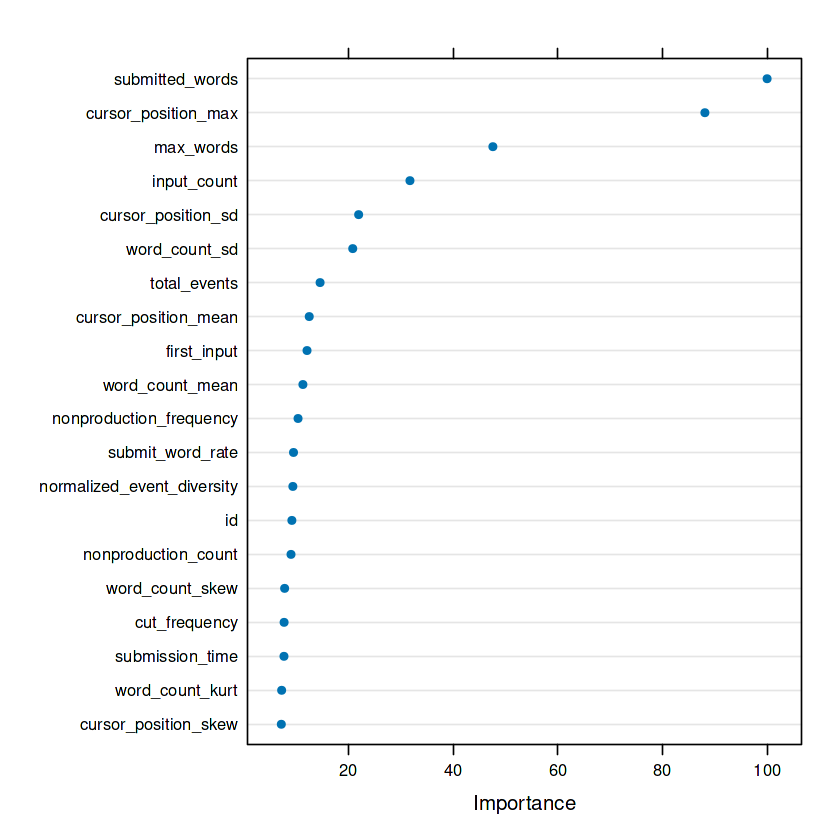

In [5]:
# Create a training control object for cross-validation
set.seed(123)
ctrl <- trainControl(method = "cv", number = 5)

# Specify the parameter grid for tuning
grid <- expand.grid(.mtry = c(2, 5, 10, 15, 20, 25, 30, 35))

# Train the model using cross-validation
set.seed(1325)
classifier_RF <- train(
  x = train_scores[, names(train_scores) != "score"],
  y = train_scores$score,
  method = "rf",
  trControl = ctrl,
  tuneGrid = grid
)

# View the tuned parameters
print(classifier_RF)

# View Feature Importance
feature_imp <- varImp(classifier_RF)
dotPlot(feature_imp)

# PREPPING THE TEST SET

In [6]:
#Combine Event Columns
test_logs <- test_logs[, names(test_logs) != "up_event"]
names(test_logs)[names(test_logs) == "down_event"] <- "event"

#Simplify Move Activities
i <- 1
while (i <= nrow(test_logs)) {
  if (substr(test_logs$activity[i+1], 1, 1) == "M" & test_logs$event[i] == "Leftclick" & test_logs$text_change[i] == "NoChange") {
    
    new_text <- sub(".*?(\\[.*?\\]).*", "\\1", test_logs$activity[i + 1])
    test_logs$text_change[i] = paste0("Highlighted ", new_text)
    test_logs$activity[i+1] <- "Move"
    rm(new_text)
    
  }
  i <- i + 1
}

#Remove extra movement info from 'undo' rows
if (substr(test_logs$activity, 1, 1) == "M" && test_logs$event == "z") {
  test_logs[substr(test_logs$activity, 1, 1) == "M" & test_logs$event == "z", ]$activity <- "Move"
}
test_logs$activity <- as.factor(test_logs$activity)
str(test_logs$activity)

#Simplify Event Values
test_logs$event <- gsub("(?i)(F[0-9]{1,2}|.*Media.*|.*Audio.*|.*Pause.*).*", "DeviceFeatureChangeKey", test_logs$event)
test_logs$event <- gsub("(?i)(Scroll.*|Meta|Dead|Process|OS|AltGraph|Mode.*)", "SpecialProcessKey", test_logs$event)
test_logs$event <- gsub("(?i)(Clear|Cancel)", "Escape", test_logs$event)
test_logs$event <- gsub("^[0-9]$", "DigitKey", test_logs$event)
test_logs$event <- gsub("(?i).*Arrow.*", "ArrowKey", test_logs$event)
test_logs$event <- gsub("(?i)(Home|End|^Page.*)", "TextJumpKey", test_logs$event)

#Compile list of allowed event values
new_event_labels <- c("^[A-Za-z]$", "^[[:punct:]]$", "click", "Shift", "Space", "Backspace", "Enter", "Tab", "Caps", "Control", "Delete", "Insert", "Escape", "Print", "RareKey", "NumLock", "Alt", "ContextMenu", "ArrowKey", "TextJumpKey", "DeviceFeatureChangeKey", "SpecialProcessKey", "DigitKey", "Unidentified")
new_valid_events <- unique(test_logs$event)[apply(sapply(new_event_labels, function(x) grepl(x, unique(test_logs$event))), 1, any)]

test_logs$event <- ifelse(test_logs$event %in% new_valid_events, test_logs$event, "Unidentified")
test_logs$event[test_logs$event %in% names(which(table(test_logs$event) < 25))] <- "RareKey"

test_logs$event <- as.factor(test_logs$event)
str(test_logs$event)
                                                         
train_scores$score <- as.factor(train_scores$score)
str(train_scores)

 Factor w/ 1 level "Input": 1 1 1 1 1 1
 Factor w/ 1 level "RareKey": 1 1 1 1 1 1
'data.frame':	2471 obs. of  35 variables:
 $ id                        : chr  "001519c8" "0022f953" "0042269b" "0059420b" ...
 $ cursor_position_max       : int  1539 1676 2291 1047 1402 1445 1438 1768 1308 4110 ...
 $ cursor_position_IQR       : num  730 630 674 527 582 ...
 $ cursor_position_median    : num  727 743 530 594 630 ...
 $ cursor_position_kurt      : num  1.74 1.96 2.89 1.8 1.75 ...
 $ cursor_position_skew      : num  0.0343 0.1314 1.0067 -0.2659 -0.0361 ...
 $ cursor_position_sd        : num  439 449 593 308 342 ...
 $ cursor_position_mean      : num  711 776 732 543 600 ...
 $ first_input               : int  106686 32706 21335 161494 94454 48664 27623 107276 174584 11380 ...
 $ submission_time           : int  1801969 1788969 1771669 1404469 1662472 1778916 1768197 1799303 1797498 1853697 ...
 $ word_count_IQR            : num  134 164 163 106 157 ...
 $ word_count_median         : num  1

# ADDING TEST FEATURES

In [7]:
#Add Features to Test Set
test_scores <- total_events(test_logs, test_scores)
test_scores <- event_diversity(test_logs, test_scores)
test_scores <- normalized_event_diversity(test_scores)
test_scores <- submitted_words(test_logs, test_scores)
test_scores <- max_words(test_logs, test_scores)
test_scores <- word_reduction(test_scores)
test_scores <- word_count_mean(test_logs, test_scores)
test_scores <- word_count_sd(test_logs, test_scores)
test_scores <- word_count_skew(test_logs, test_scores)
test_scores <- word_count_kurt(test_logs, test_scores)
test_scores <- word_count_median(test_logs, test_scores)
test_scores <- word_count_IQR(test_logs, test_scores)
test_scores <- submission_time(test_logs, test_scores)
test_scores <- first_input(test_logs, test_scores)
test_scores <- writing_time(test_scores)
test_scores <- submit_word_rate(test_scores)
test_scores <- max_word_rate(test_scores)
test_logs <- normalized_cursor_position(test_logs, test_scores)
test_scores <- cursor_position_mean(test_logs, test_scores)
test_scores <- cursor_position_sd(test_logs, test_scores)
test_scores <- cursor_position_skew(test_logs, test_scores)
test_scores <- cursor_position_kurt(test_logs, test_scores)
test_scores <- cursor_position_median(test_logs, test_scores)
test_scores <- cursor_position_IQR(test_logs, test_scores)
test_scores <- cursor_position_max(test_logs, test_scores)
test_scores <- input_count(test_logs, test_scores)
test_scores <- cut_count(test_logs, test_scores)
test_scores <- paste_count(test_logs, test_scores)
test_scores <- move_count(test_logs, test_scores)
test_scores <- replace_count(test_logs, test_scores)
test_scores <- nonproduction_count(test_logs, test_scores)
test_scores <- input_frequency(test_scores)
test_scores <- nonproduction_frequency(test_scores)
test_scores <- cut_frequency(test_scores)

cat("\n", "\n", "TRAIN_SCORES VARIABLES:", "\n")
print(names(train_scores))

cat("\n", "\n", "TEST_SCORES VARIABLES:", "\n")
print(names(test_scores))

print(classifier_RF)

test_scores[test_scores == "NaN"] <- 0
test_scores[test_scores == "Inf"] <- 0
test_scores[is.na(test_scores)] <- 0


 
 TRAIN_SCORES VARIABLES: 
 [1] "id"                         "cursor_position_max"       
 [3] "cursor_position_IQR"        "cursor_position_median"    
 [5] "cursor_position_kurt"       "cursor_position_skew"      
 [7] "cursor_position_sd"         "cursor_position_mean"      
 [9] "first_input"                "submission_time"           
[11] "word_count_IQR"             "word_count_median"         
[13] "word_count_kurt"            "word_count_skew"           
[15] "word_count_sd"              "word_count_mean"           
[17] "max_words"                  "submitted_words"           
[19] "event_diversity"            "total_events"              
[21] "score"                      "normalized_event_diversity"
[23] "word_reduction"             "writing_time"              
[25] "submit_word_rate"           "max_word_rate"             
[27] "input_count"                "cut_count"                 
[29] "paste_count"                "move_count"                
[31] "replace_count"      

# MAKE PREDICTIONS

In [8]:
test_predictions <- predict(classifier_RF, newdata = test_scores)
sample_submission <- data.frame(id = test_scores$id, score = test_predictions) 
write_csv(sample_submission, "submission.csv")